<a href="https://colab.research.google.com/github/kashimmirza/AI_in_Medicine_Clinical_Imaging_Classification/blob/master/lastmodifiedmodelcse465.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [49]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
!pip install wheel
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [51]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])
print(type(train_transformer))
print(dir(transforms))


val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

test_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

<class 'torchvision.transforms.transforms.Compose'>
['AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSizedCrop', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'Scale', 'TenCrop', 'ToPILImage', 'ToTensor', 'TrivialAugmentWide', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'autoaugment', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


In [52]:
'/content/drive/MyDrive/colab note books/datasets/'

'/content/drive/MyDrive/colab note books/datasets/'

In [53]:
# Make a directory to store the data.
import zipfile
DATASET_ZIP_DIR = '/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CT_COVID.zip'
DATASET_ZIP_DIR1 = '/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CT_NonCOVID.zip'

# Unzip data in the newly created directory.
with zipfile.ZipFile(DATASET_ZIP_DIR, "r") as z_fp:
    z_fp.extractall("/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CTIMAGE")

# Unzip data in the newly created directory.
with zipfile.ZipFile(DATASET_ZIP_DIR1, "r") as z_fp:
    z_fp.extractall("/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CTIMAGE")



In [54]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=False):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CTIMAGE',
                              txt_COVID='/content/drive/MyDrive/colab note books/datasets/new_data/new_txt/train.txt',
                              txt_NonCOVID='/content/drive/MyDrive/colab note books/datasets/old_data/old_txt/trainctnoncovid.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CTIMAGE',
                              txt_COVID='/content/drive/MyDrive/colab note books/datasets/new_data/new_txt/val.txt',
                              txt_NonCOVID='/content/drive/MyDrive/colab note books/datasets/old_data/old_txt/valctnoncovid.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='/content/drive/MyDrive/colab note books/datasets/new_data/4.4image/CTIMAGE',
                              txt_COVID='/content/drive/MyDrive/colab note books/datasets/new_data/new_txt/testct_covid.txt',
                              txt_NonCOVID='/content/drive/MyDrive/colab note books/datasets/old_data/old_txt/testct_noncovid.txt',
                              transform= test_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

425
118
203


torch.Tensor

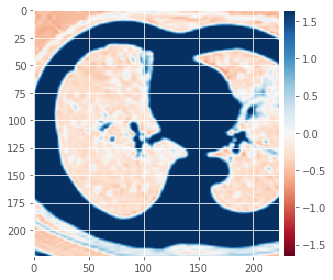

In [55]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())
data.shape
type(data)

In [56]:
#simple cnn model
import torch
import torch.nn as nn
# from torchvision.models.utils import load_state_dict_from_url


class CNN(nn.Module):

    def __init__(self, num_classes=1000, init_weights=True):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class Linear(nn.Module):

    def __init__(self, num_classes=1000, init_weights=True):
        super(Linear, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(224*224*3, num_classes),
        )

    def forward(self, x):

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class MLP(nn.Module):

    def __init__(self, num_classes=1000, init_weights=True):
        super(MLP, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(224*224*3, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64,num_classes)
        )

    def forward(self, x):

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class SimpleCNN(torch.nn.Module):
    def __init__(self,num_classes=1000,):
        super(SimpleCNN, self).__init__()  # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))

        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        self.layer1 = layer1

        layer3 = torch.nn.Sequential()
        layer3.add_module('fc1', torch.nn.Linear(401408, num_classes))
        self.layer3 = layer3

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer3(fc_input)
        return fc_out

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [58]:
features = 16
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

In [59]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [61]:
def vae_loss(output, input, mean, logvar, loss_func):
    recon_loss = loss_func(output, input)
    kl_loss = torch.mean(0.5 * torch.sum(
        torch.exp(logvar) + mean**2 - 1. - logvar, 1))
    return recon_loss + kl_loss

In [62]:
class VAE(nn.Module):
    def __init__(self, in_shape, n_latent):
        super().__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        c,h,w = in_shape
        self.z_dim = h//2**2 # receptive field downsampled 2 times
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(c),
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # 32, 16, 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32, 8, 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.z_mean = nn.Linear(64 * self.z_dim**2, n_latent)
        self.z_var = nn.Linear(64 * self.z_dim**2, n_latent)
        self.z_develop = nn.Linear(n_latent, 64 * self.z_dim**2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1),
            CenterCrop(h,w),
            nn.Sigmoid()
        )

    def sample_z(self, mean, logvar):
        stddev = torch.exp(0.5 * logvar)
        noise = Variable(torch.randn(stddev.size()))
        return (noise * stddev) + mean

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.z_mean(x)
        var = self.z_var(x)
        return mean, var

    def decode(self, z):
        out = self.z_develop(z)
        out = out.view(z.size(0), 64, self.z_dim, self.z_dim)
        out = self.decoder(out)
        return out

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.sample_z(mean, logvar)
        out = self.decode(z)
        return out, mean, logvar
    

In [63]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [64]:

#optimizer = optim.Adam(model.parameters(), lr=lr)
#criterion = nn.BCELoss(reduction='sum')

In [65]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [66]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [67]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [68]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

NameError: ignored

In [ ]:

def train(model, loader, loss_func, optimizer):
    model.train()
    for inputs, _ in loader:
        inputs = Variable(inputs)

        output, mean, logvar = model(inputs)
        loss = vae_loss(output, inputs, mean, logvar, loss_func)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

In [ ]:
def reparameterise(self, mu, logvar):
    if self.training:
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    else:
        return mu

def forward(self, x):
    mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
    mu = mu_logvar[:, 0, :]
    logvar = mu_logvar[:, 1, :]
    z = self.reparameterise(mu, logvar)
    return self.decoder(z), mu, logvar

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [77]:
def train(optimizer, epoch, floodlevel = 0):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        output = model(data)
        
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        # add flooding
        loss = (loss-floodlevel).abs() + floodlevel
        
#         print(loss)
        
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
    print('Epoch: {} Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch,
        train_loss/np.ceil(len(train_loader.dataset)/batch_size), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))

In [78]:
def val():
    
    model.train()
    
    val_loss = 0
    val_correct = 0
    
    for batch_index, batch_samples in enumerate(val_loader):
        
        with torch.no_grad():
        
            # move data to device
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            criteria = nn.CrossEntropyLoss()
            loss = criteria(output, target.long())
            val_loss += loss
            
            val_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
    print('\tVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss/np.ceil(len(val_loader.dataset)/batch_size), val_correct, len(val_loader.dataset),
        100.0 * val_correct / len(val_loader.dataset)))

In [79]:
def predict():
    
    model.eval()
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        
        indexlist = []
        labellist = []

        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, index = batch_samples['img'].to(device), batch_samples['index'].cpu().numpy()
            
            output = model(data)
            
            pred = output.argmax(dim=1, keepdim=True).cpu().squeeze().numpy()
            labellist.extend(list(pred))
            indexlist.extend(list(index))
           
    return indexlist, labellist

In [72]:
### ResNet50
import torchvision.models as models
model = models.resnet50(pretrained=True).to(device)
modelname = 'ResNet50'

In [ ]:
# ResNet18
import torchvision.models as models
model = models.resnet18(pretrained=True).to(device)
modelname = 'ResNet18'

In [ ]:
# Adjust hyperparameters here
l2_loss = 0.01
floodlevel = 0.01
lr = .0001
n_epochs = 50 # number of epochs to train for
batch_size = 32 # batch size for training, validation and test data loaders
lr = 0.0001 # Learning rate for Adam
val_prop = 0.2 # proportion of training images to be used as validation
val_iter = 10 # number of epochs before testing validation set

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = l2_loss)

# Initial validation set loss (to verify model is training from scratch)
val()
for epoch in range(n_epochs):
    train(optimizer, epoch,floodlevel)
    if epoch%val_iter == 9:
        val()

	Val set: Average loss: 63.0135, Accuracy: 0/118 (0%)
Epoch: 0 Train set: Average loss: 18.5480, Accuracy: 260/425 (61%)
Epoch: 1 Train set: Average loss: 4.1256, Accuracy: 333/425 (78%)
Epoch: 2 Train set: Average loss: 3.8671, Accuracy: 334/425 (79%)
Epoch: 3 Train set: Average loss: 3.2881, Accuracy: 349/425 (82%)
Epoch: 4 Train set: Average loss: 2.8494, Accuracy: 370/425 (87%)
Epoch: 5 Train set: Average loss: 2.9606, Accuracy: 355/425 (84%)
Epoch: 6 Train set: Average loss: 3.0213, Accuracy: 350/425 (82%)
Epoch: 7 Train set: Average loss: 2.7895, Accuracy: 357/425 (84%)
Epoch: 8 Train set: Average loss: 2.4564, Accuracy: 370/425 (87%)
Epoch: 9 Train set: Average loss: 2.3465, Accuracy: 376/425 (88%)
	Val set: Average loss: 9.3082, Accuracy: 61/118 (52%)
Epoch: 10 Train set: Average loss: 2.4965, Accuracy: 368/425 (87%)
Epoch: 11 Train set: Average loss: 2.7814, Accuracy: 370/425 (87%)
Epoch: 12 Train set: Average loss: 2.3400, Accuracy: 374/425 (88%)
Epoch: 13 Train set: Average 

In [ ]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D , Lambda
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
!pip install keras.optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(rotation_range = 5, zoom_range = [0.9, 1.2], horizontal_flip = True, height_shift_range = [-5,5], width_shift_range = [-5,5])

In [ ]:
train_gen.fit(trainset)

In [ ]:
input_shape = (150, 150, 3)
classes  = 2
epochs = 100
batch_size = 6

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])